<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Alphabets Dataset

Cloning into 'mini_proj3'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 206 (delta 32), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (206/206), 8.51 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (97/97), done.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

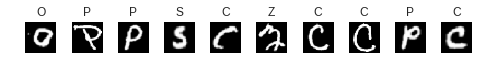

In [5]:
#!git clone "https://github.com/puraminy/mini_proj3"
!rm -r 'mini_proj3'
!git clone "https://github.com/puraminy/mini_proj3"
from mini_proj3.mysom import MiniSom

import numpy as np
alphabet = np.load('mini_proj3/Alphabets.npy')
label = np.load('mini_proj3/Alphabet_labels.npy')
label2 = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z']


import matplotlib.pyplot as plt
idx = np.random.randint(499, size=10)

fig, axes = plt.subplots(1, 10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.5)

# for i in range(len(alphabet)):
#   alphabet[i] = alphabet[i] * (255.0 / alphabet[i].max())

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
alphabet = sc.fit_transform(alphabet)
  
pltalpha = alphabet[idx,:]
pltlbl = label[idx]

for i in range(10):
  axes[i].imshow(-1*np.reshape(pltalpha[i,:],[28,28]))
  axes[i].axis('off')
  xlabel = label2[pltlbl[i]]; axes[i].set_title(xlabel)



alphabet.shape, label.shape, max(label), min(label)


#SOM

##Constant Parameters

##Decay Functions

In [0]:
# -*- coding: utf-8 -*-

def decay_iter(lr, t, max_iter):
    ret = lr / (1 + t / (max_iter / 2))
#     print("ret:", ret)
#     print('.', end='')
    return ret

def decay_hendesi(lr, t, max_iter):
    ret = lr * (0.99**t) #np.exp(-t*0.001)
#     print(f"ret {t}:", ret)
#     print('.', end='')
    return ret

def decay_exp(lr, t, max_iter):
    ret = lr * np.exp(-t*0.008)
#     print(f"ret {t}:", ret)
#     print('.', end='')
    return ret

def decay_hesabi(lr, t, max_iter):
    ret = lr - (t*1/max_iter)     
#     print(f"hsabi {t}:", ret)
#     print('.', end='')
    return ret

/content/mini_proj3/mysom.py:186: RuntimeWarning: divide by zero encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/content/mini_proj3/mysom.py:186: RuntimeWarning: invalid value encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/content/mini_proj3/mysom.py:187: RuntimeWarning: invalid value encountered in true_divide
  ay = exp(-power(self._neigy-c[1], 2)/d)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


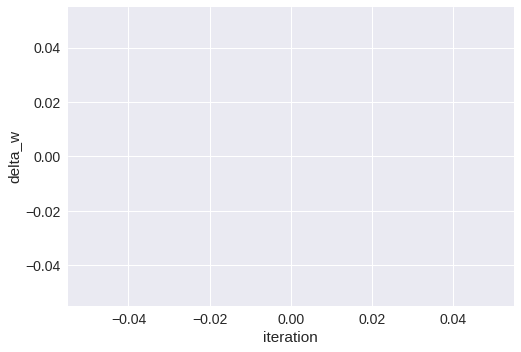

In [11]:
x = 625; y = 1
radius = 0

# neighborhood='mexican_hat'
# neighborhood='bubble'
neighborhood='gaussian'
# neighborhood='triangle'

som = MiniSom(x=x, y=y, input_len=28*28,sigma=radius, learning_rate=1, neighborhood_function=neighborhood) 
som.random_weights_init(alphabet)
#som.random_weights_init(alphabet)  # initialize weights with random values 
som.train_delta(alphabet, delta=0.0001, max_iteration=4000,
                decay_lr=decay_hendesi,
                decay_sigma=decay_hendesi,
                delta_func='max')

weightsA = som._weights



/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


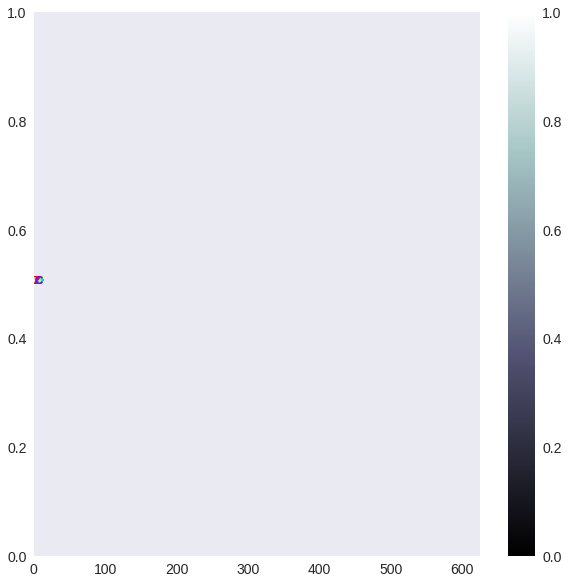

Number of Winning Nodes: 1


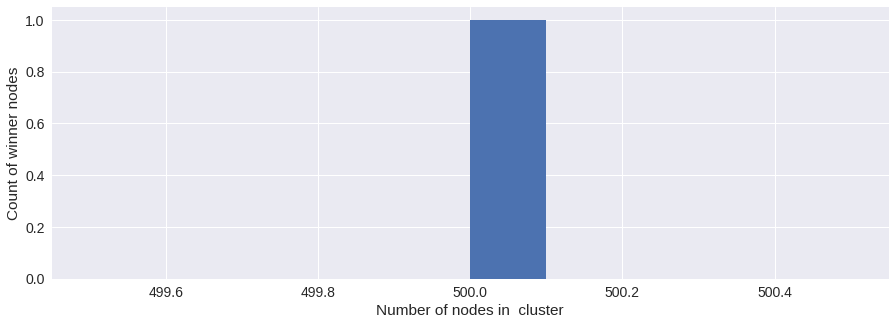

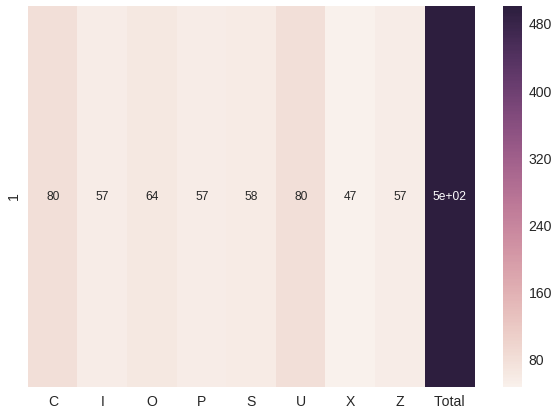

In [12]:

plt.figure(figsize=(10, 10))

from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()

for x, t in zip(alphabet, label):  # scatterplot
     w = som.winner(x)
#      print("winner=", w, " label:" , label2[t])
     plt. text(w[0]+.5,
               w[1]+.5,
               label2[t],
               color=plt.cm.rainbow(t / 7.),
               fontdict={'weight': 'bold',  'size': 11}
               )

plt.show()

mappings = som.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
vv = []
for key, val in mappings.items():
    vv.append(len(val))
    
# print("VV = ", vv)
  
plt.hist(vv)
plt.ylabel('Count of winner nodes')
plt.xlabel('Number of nodes in  cluster')
# plt.xticks(x+.5, ['a','b','c'])

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = np.linspace(1,result_mat.shape[0],result_mat.shape[0], dtype='int')
aylabels = [str(i) for i in aylabels]
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()
